In [12]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from statistics import mode
from statistics import mean
from random import randint
from math import sqrt
import networkx as nx

warnings.filterwarnings("ignore")

In [37]:
def clean(df):
    colors_cleaned = [c.strip().lower().translate(string.punctuation) for c in df['colour_name']]
    # lowercase all letters, strip, and remove punctuation from color names
    df.pop('colour_name')  # remove the unprocessed color names, use processed ones
    df.pop('sample_id')  # this column is unneeded
    df['color'] = colors_cleaned  # processed color names

    return df

df = pd.read_csv('colour_naming_data-1.csv')
df = clean(df)
print(df.head())

     R    G    B              color
0   77   72   52         dark khaki
1   77   38   28         dark brown
2  111  120  164  pale greyish blue
3  212  160  187          pale pink
4  112  163   70        light green


Initial preprocessing step--Prepare the dataframe by removing whitespace, lowercasing all characters, and removing punctuation from the color names. Remove the sample_id column as well because it is not relevant to the assignment.

In [38]:
def unique_rgb_parsing(df):
    # finding most common color prediction per rgb value
    rgb_to_color = {} # dict used to store color predictions per rgb
    unique_rgb = [] # 2d list that i will create new dataframe from

    for index, row in df.iterrows():
        rgb = tuple([row['R'], row['G'], row['B']]) # will be used as key
        if rgb in rgb_to_color.keys():
            rgb_to_color[rgb].append(row['color'])
            # each rgb will correspond to a list of all the predictions it has
            # if this rgb value has been seen before, append current prediction to value list
        else:
            rgb_to_color[rgb] = [row['color']]
            # if this rgb value is new, create new list as its value with current prediction

    for rgb in rgb_to_color.keys():
        colors = rgb_to_color[rgb]
        most_common = mode(colors) # statistics.mode gets most common prediction
        # in the case of a tie, the first one to appear will be used
        unique_rgb.append([int(rgb[0]), int(rgb[1]), int(rgb[2]), most_common])
        # 2d list, each inner list is [R, G, B, color name]

    df2 = pd.DataFrame(unique_rgb, columns=['R', 'G', 'B', 'color'])
    # create & return new dataframe from unique_rgb 2d list
    return df2

df2 = unique_rgb_parsing(df) # df2 will be the dataframe with unique values
print(df2.head())

     R    G    B        color
0   77   72   52   dark khaki
1   77   38   28        brown
2  111  120  164         blue
3  212  160  187         pink
4  112  163   70  light green


Further preprocessing for regression--Currently, many RGB values show up multiple times in the dataframe, each with its own set of predictions. This step further processes the dataframe by converting the dataframe into one where each RGB value only shows up once, and the color it corresponds to is the most common prediction. In the event of a tie for most common prediction, the prediction that shows up first will be chosen.

In [7]:
def preprocess(df):
    colors = df.pop('color').values  # y value, or the names of the colors
    rgb = df.values  # x values, or the rgb values

    # setting up train/test
    X_train, X_test_nonnormalized, y_train, y_test = train_test_split(rgb, colors,
                                            test_size=0.2, random_state=4)

    scaler = StandardScaler()
    X_train, X_test = (scaler.fit_transform(X_train),
                       scaler.transform(X_test_nonnormalized))
    # need to normalize input values

    return X_train, X_test, y_train, y_test, X_test_nonnormalized

X_train, X_test, y_train, y_test, X_test_nonnormalized = preprocess(df2)
# returns train/test values


This is an intermediate step that normalizes the values in the dataframe according to the sklearn StandardScaler, and splits it into train and test portions

In [8]:
def regress(upper_bound, X_train, X_test, y_train, y_test):
    # each element of fitness_scores will be an array of:
    # [n_neighbors, precision_score, recall_score, f1_score]
    # this function takes upper bound of n_neighbors as input
    fitness_scores = []
    # loop through n_neighbors to test each one's performance
    for i in range(1, upper_bound + 1):
        knn = KNeighborsClassifier(n_neighbors=i)
        # KNeighborsClassifier for categorical output

        knn.fit(X_train, y_train) # fit the model
        y_pred = knn.predict(X_test) # test the model on test values
        # print(y_pred)

        prec = round(precision_score(y_pred, y_test, average='weighted',
                                     zero_division=0), 3)
        rec = round(recall_score(y_pred, y_test, average='weighted',
                                 zero_division=0), 3)
        # the recall score is equal to the knn.score metric
        f1 = round(f1_score(y_pred, y_test, average='weighted', zero_division=0), 3)
        # get precision, recall, and f1 scores, add to array
        # zero_division=0 argument is used to avoid edge cases where output values
        # can be chosen 0 times; this is due to average=weighted argument
        fitness_scores.append([i, prec, rec, f1])

        print(f"The weighted precision score, weighted recall score, "
              f"and weighted f1 score for {i} "
              f"neighbor(s) are {prec}, {rec}, and {f1} respectively")
        # print performance of each one

    # recall score is the most accurate measure of fitness for knn
    # get the number of neighbors that resulted in the highest accuracy measure
    recall_scores = [f[2] for f in fitness_scores]
    best_n_neighbors = recall_scores.index(max(recall_scores)) + 1

    best_knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
    best_knn.fit(X_train, y_train)
    y_pred = best_knn.predict(X_test)
    # fit the best knn to the same training data

    return fitness_scores, best_knn, y_pred
    # return fitness_scores for use in fitness_graphs
    # return knn with highest recall score for use in predictions_vs_centroids
    # return y_pred for use in 3d scatter plot

fitness_scores, knn, y_pred = regress(12, X_train, X_test, y_train, y_test)


The weighted precision score, weighted recall score, and weighted f1 score for 1 neighbor(s) are 0.361, 0.325, and 0.326 respectively
The weighted precision score, weighted recall score, and weighted f1 score for 2 neighbor(s) are 0.428, 0.342, and 0.366 respectively
The weighted precision score, weighted recall score, and weighted f1 score for 3 neighbor(s) are 0.451, 0.358, and 0.388 respectively
The weighted precision score, weighted recall score, and weighted f1 score for 4 neighbor(s) are 0.434, 0.367, and 0.388 respectively
The weighted precision score, weighted recall score, and weighted f1 score for 5 neighbor(s) are 0.556, 0.408, and 0.452 respectively
The weighted precision score, weighted recall score, and weighted f1 score for 6 neighbor(s) are 0.597, 0.408, and 0.466 respectively
The weighted precision score, weighted recall score, and weighted f1 score for 7 neighbor(s) are 0.598, 0.417, and 0.479 respectively
The weighted precision score, weighted recall score, and weigh

This code block is the "meat" of the regression logic, which iterates from k=1 to k=12 and trains a KNN for each k value. 
It returns the KNN with the highest recall score, as the recall score is the most accurate measure of the suitability of a KNN. It also returns a 2d list with the fitness scores to be used in a graph later, as well as the predicted y values to be used in the 3d scatter plot.
It takes in an upper_bound input to be used for testing k values for scalability purposes, but upper_bound=12 will be used according to the problem specifications. 

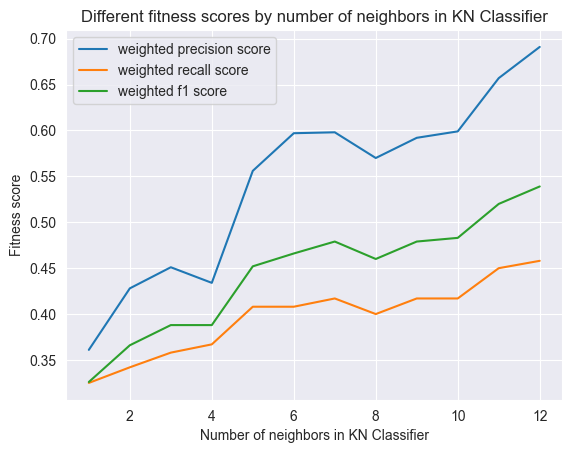

In [9]:
def fitness_graphs(fitness_scores):
    # fitness_scores is a 2d list
    # each inner list is [k value, weighted precision, weighted recall, 
    # weighted f1]
    graph_x_values = [f[0] for f in fitness_scores]
    graph_y1 = [f[1] for f in fitness_scores]
    graph_y2 = [f[2] for f in fitness_scores]
    graph_y3 = [f[3] for f in fitness_scores]

    plt.plot(graph_x_values, graph_y1, label ='weighted precision score')
    plt.plot(graph_x_values, graph_y2, label ='weighted recall score')
    plt.plot(graph_x_values, graph_y3, label ='weighted f1 score')
    # plot 3 different lines

    plt.xlabel("Number of neighbors in KN Classifier")
    plt.ylabel("Fitness score")
    plt.legend()
    plt.title('Different fitness scores by number of neighbors in KN Classifier')
    plt.show()

fitness_graphs(fitness_scores)

This step graphs the weighted precision, recall, and f1 scores against the number of neighbors in the classifier. Notably, at k=12, the scores still have an upwards trend, which I will address later.

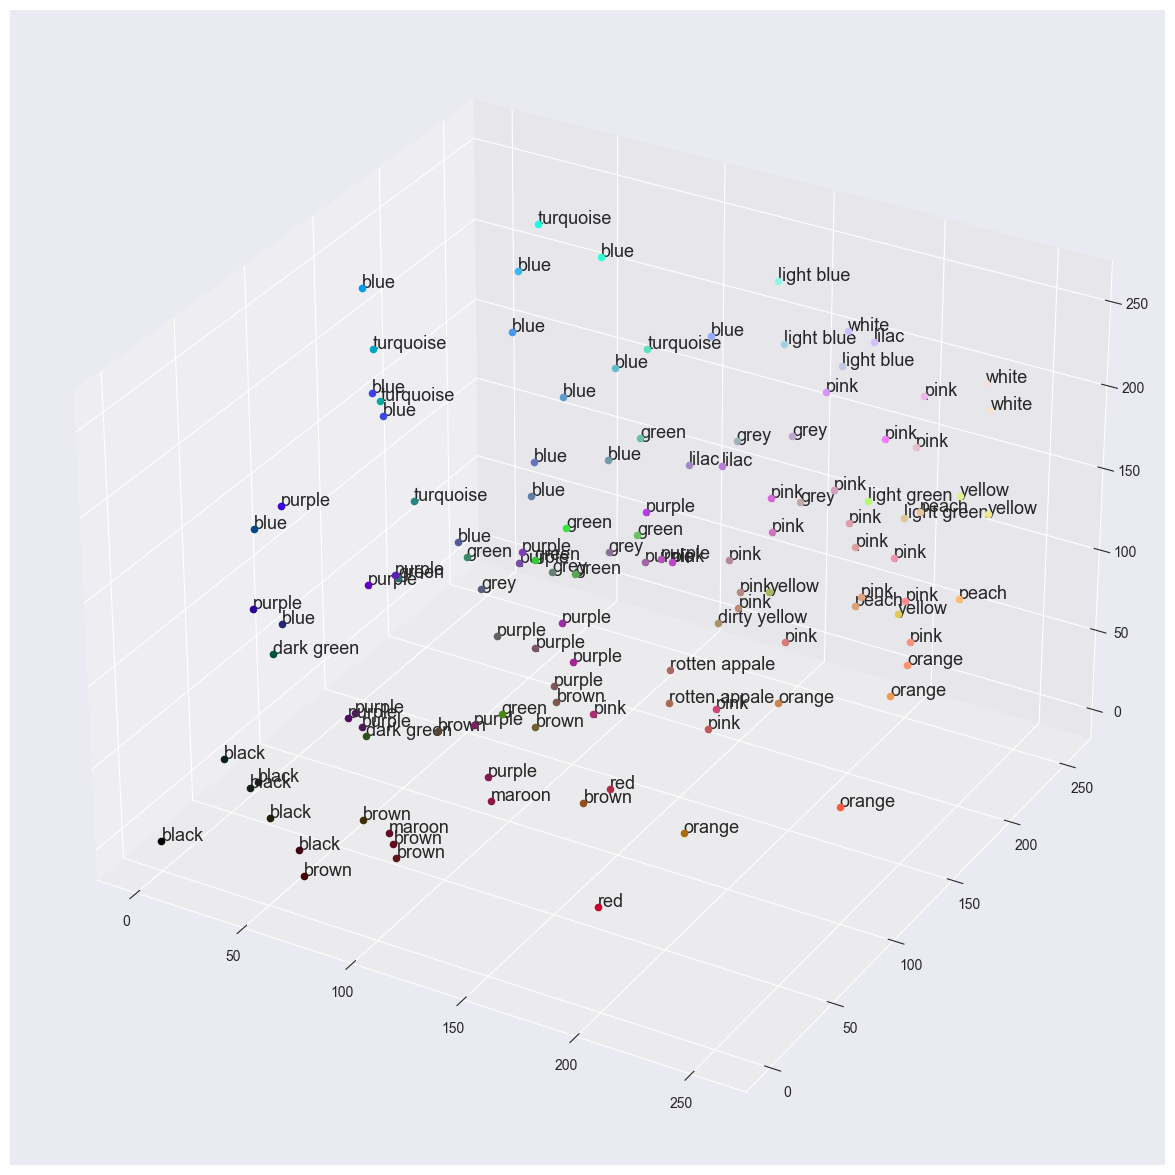

In [13]:
def three_d_scatter(X_test, y_pred):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(projection='3d')

    x_values = [x[0] for x in X_test]
    y_values = [x[1] for x in X_test]
    z_values = [x[2] for x in X_test]

    for i in range(len(x_values)):
        ax.scatter(x_values[i], y_values[i], z_values[i],
                   c=(x_values[i] / 255, y_values[i] / 255, z_values[i] / 255))
        ax.text(x_values[i], y_values[i], z_values[i], y_pred[i], size=13, zorder=1)
    # the c value needs to be divided by 255 because it takes inputs
    # from 0 to 1, not 0 to 255
    plt.show()

three_d_scatter(X_test_nonnormalized, y_pred)


This block creates a 3d scatter plot that graphs the r, g, and b values against the predicted output. Each point is labeled with how the rgb value would be displayed, as well as the predicted value. Notably, the c arguments in the ax.scatter line needs to be divided by 255 because it takes inputs from 0 to 1, not 0 to 255. 

In [17]:
def generate_centroids(df):
    """
    (use original dataset for this):
    for each color, average out every set of rgb values that was predicted to be
    that color, and treat the resulting mean as the centroid
    """
    color_to_rgb = {}
    for index, row in df.iterrows():
        rgb = tuple([row['R'], row['G'], row['B']]) # will be used as value
        c = row['color']
        

        if c in color_to_rgb.keys():
            color_to_rgb[c].append(rgb)
        else:
            color_to_rgb[c] = [rgb]
        
        # color_to_rgb is a dict with each key as a color name, and each value a list of all the rgb values that resulted in it being predicted

    color_to_rgb_centroid_dict = {}
    color_to_rgb_centroid_list = []
    for color in color_to_rgb.keys():
        avg_r = mean([r[0] for r in color_to_rgb[color]])
        avg_g = mean([r[1] for r in color_to_rgb[color]])
        avg_b = mean([r[2] for r in color_to_rgb[color]])

        color_to_rgb_centroid_dict[color] = list([avg_r, avg_g, avg_b])
        color_to_rgb_centroid_list.append(list([color, avg_r, avg_g, avg_b]))   
    # create dict and list

    # color_to_rgb_centroid_dict used in predictions_vs_centroids
    # color_to_rgb_centroid_list used in weighted_graph
    for key, value in color_to_rgb_centroid_dict.items():
        print(f"{key}: {value}")
    return color_to_rgb_centroid_dict, color_to_rgb_centroid_list

centroids_dict, centroids_list = generate_centroids(df) # use original df that has duplicates for this


dark khaki: [77, 72, 52]
dark brown: [60.16, 34.64, 20.36]
pale greyish blue: [111, 120, 164]
pale pink: [219.5, 164.27272727272728, 192.04545454545453]
light green: [117.4423076923077, 204.28846153846155, 135.65384615384616]
lime-green: [147.16666666666666, 193.5, 58]
vivid green: [26, 200.5, 104]
purplish blue: [85.5, 89, 162.5]
pale magenta: [156.66666666666666, 104, 152.66666666666666]
purple: [119.84386617100371, 55.44981412639405, 146.18215613382898]
dark navy blue: [31, 0, 101]
pink: [220.5, 111.97457627118644, 174.73728813559322]
red: [181.14285714285714, 36.25, 49.964285714285715]
vivid pink: [255, 63, 196]
white: [227.9047619047619, 221.16666666666666, 229.78571428571428]
chocolate: [89, 67, 59]
pale brown: [141, 100, 81]
very light green: [179, 210, 168]
brown: [111.17857142857143, 67.10714285714286, 36.67857142857143]
dark magenta: [144.2, 31, 130.6]
pale brick: [166, 105, 121]
light pink: [228.06896551724137, 165.9655172413793, 208.72413793103448]
bordeaux: [91.4, 21.2, 48

This block of code creates a "centroid" for each color prediction by averaging the individual r, g, and b predictions for that color from the original dataset--not the version used previously that only has one of each RGB value. It returns a dict for usage in the upcoming bar graph, and a list to be used for the upcoming weighted graph. The print output is a slightly cleaner version of the dict that was created.

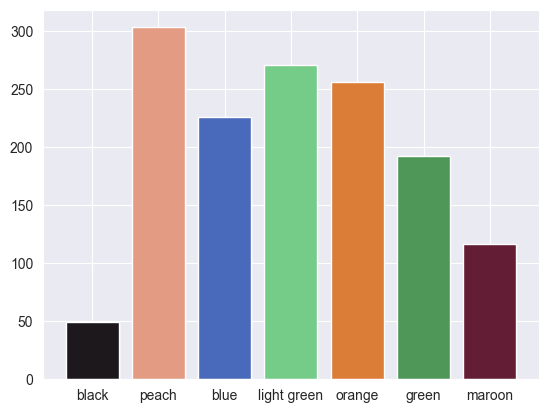

In [30]:
def predictions_vs_centroids(df, knn, centroids, X_test, loops=10):
    """
    then for each color that is predicted, take the euclidean distance between
    the input rgb, and the centroid rgb of that color
    """
    distances = []
    l = len(X_test)

    for i in range(1, loops + 1):
        index = randint(0, l - 1)
        r, g, b = X_test[index][0], X_test[index][1], X_test[index][2]
        prediction = knn.predict([[r, g, b]])[0]
        # trained knn is passed as function input, this predicts on random rgb
        rgb = centroids[prediction]
        # centroids are passed in as function input
        # this gets centroids of the prediction

        r1, g1, b1 = rgb[0], rgb[1], rgb[2] # separate rgb value for calculations

        distance = sqrt((r1 - r) ** 2 + (g1 - g) ** 2 + (b1 - b) ** 2)
        # euclidean distance
        distances.append([rgb, prediction, distance])
        # appends [[list of rgb], prediction color name, euclidean distance]

    # create bar graph
    fig, ax = plt.subplots()
    # print(distances)

    colors = [[rgb[0][0], rgb[0][1], rgb[0][2]] for rgb in distances]
    color = [(c[0] / 255, c[1] / 255, c[2] / 255) for c in colors]
    # each bar will be colored as the rgb that generated it

    ax.bar([d[1] for d in distances], [d[2] for d in distances], color=color)
    plt.show()

predictions_vs_centroids(df, knn, centroids_dict, X_test,10)


This code block takes 10 randomly selected RGB values from the input dataset, uses the best-fitted KNN from earlier to predict a color name, and then computes the Euclidean distance from the centroid of that color name to the input RGB values. This Euclidean distance is then graphed on a bar plot. 
Notably, the same color is very often chosen for multiple inputs, so only the first color of that name will be displayed. The variance in the distance can be quite high, as well. 

In [31]:
def most_common_colors(df, n):
    # n is the number of most common colors to be generated
    return df['color'].value_counts()[:n].index.tolist()

This is a helper function that will be used to generate the weighted graph. Displaying a weighted graph for all 600 unique colors would be nigh impossible, so a few of the most commonly guessed colors are chosen to represent the graph. The value of n=10 will be used for the following graph. 

In [32]:
def distance_normalized(r1, g1, b1, r2, g2, b2):
    """
    # helper function for weighted_graph
    # so the arithmetic doesnt take up as much space
    # returns the euclidean distance between two colors divided by sqrt(255^2 * 3)
    # this is a number from 0-1, and gets higher if two colors are further apart
    """
    return sqrt((r1 - r2) ** 2 + (g1 - g2) ** 2 + (b1 - b2) ** 2) / sqrt(255 ** 2 * 3)

This is another helper function for weighted_graph. It computes Euclidean distance between two numbers and divides it by sqrt(255^2 * 3), which is used to calculate the weight between two colors. It is a rather common operation, so it is defined in a separate function to make weighted_graph more readable. 

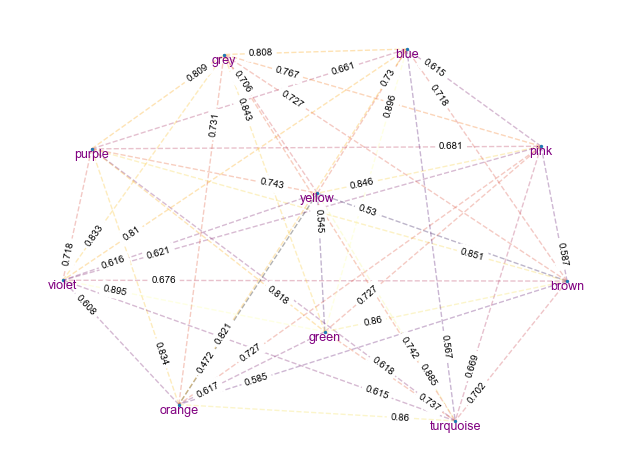

In [42]:
def weighted_graph(centroids, most_common_colors):
    """Alice uses object-oriented methods to create and visualise a weighted
    graph of colour synonyms where each node is the centroid of each
    unique colour name in the dataset connected to all other nodes by edges
    weighted by their distance.
    """

    G_full = nx.Graph()
    G = nx.Graph()
    # G_full will include all of the colors together
    # G will be the graph to be displayed, which only has
    # connections between the 10 most commonly guessed colors

    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            G_full.add_edge(centroids[i][0], centroids[j][0],
                weight=round(1 - distance_normalized(centroids[i][1],
                    centroids[j][1], centroids[i][2], centroids[j][2],
                        centroids[i][3],centroids[j][3]), 3
            ))
            if (centroids[i][0] in most_common_colors
                    and centroids[j][0] in most_common_colors):
                # the 10 most commonly guessed colors in displayed graph
                G.add_edge(centroids[i][0], centroids[j][0],
                    weight=round(1 - distance_normalized(centroids[i][1],
                         centroids[j][1], centroids[i][2], centroids[j][2],
                         centroids[i][3], centroids[j][3]), 3
                             ))
    """if the raw Euclidean distance was used for weighting, a higher 
    distance would mean a higher weight, which seems counterintuitive
    Thus, 1 - distance_normalized is used for the weight
    Interpret this as closer colors having a higher weight
    """
    pos = nx.spring_layout(G, seed=7)
    # positions for all nodes - seeded for reproducibility

    # node labels
    nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif",
                            font_color='purple',verticalalignment='top')

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=2)

    # edges
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    # this creates two tuples: edges is a tuple of pairs of colors which represent connections
    # weights is a tuple of floats from 0-1 that represent the weights in order
    weights = tuple([w for w in weights])
    # original weights get higher as the colors are further apart
    # this is counterintuitive, so weights = 1 - weights rectifies that

    nx.draw_networkx_edges(
        G, pos, edgelist=edges, width=1, alpha=0.3, edge_color=weights,
        edge_cmap=plt.cm.inferno, style="dashed")
        # higher weights (further apart) tend towards purple-ish
        # lower weights (closer together) tend towards orange or yellow

    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=7, label_pos=0.2)

    ax = plt.gca()
    ax.margins(0.05)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

common_colors = most_common_colors(df, 10)
weighted_graph(centroids_list, common_colors)

This code block uses the networkx module to create a weighted graph between the 10 most commonly chosen colors. The weights are represented as 1 - (normalized Euclidean distance), where normalized Euclidean distance is the distance between the two centroids divided by sqrt(255^2 * 3). The "inferno" color map was chosen, and in this representation higher weights tend towards orange-yellow and lower weights tend towards pink or purple. 

Note that including many more colors than this will make the graph extremely hard to read, as well as increasing runtime exponentially.

The weighted precision score, weighted recall score, and weighted f1 score for 1 neighbor(s) are 0.361, 0.325, and 0.326 respectively
The weighted precision score, weighted recall score, and weighted f1 score for 2 neighbor(s) are 0.428, 0.342, and 0.366 respectively
The weighted precision score, weighted recall score, and weighted f1 score for 3 neighbor(s) are 0.451, 0.358, and 0.388 respectively
The weighted precision score, weighted recall score, and weighted f1 score for 4 neighbor(s) are 0.434, 0.367, and 0.388 respectively
The weighted precision score, weighted recall score, and weighted f1 score for 5 neighbor(s) are 0.556, 0.408, and 0.452 respectively
The weighted precision score, weighted recall score, and weighted f1 score for 6 neighbor(s) are 0.597, 0.408, and 0.466 respectively
The weighted precision score, weighted recall score, and weighted f1 score for 7 neighbor(s) are 0.598, 0.417, and 0.479 respectively
The weighted precision score, weighted recall score, and weigh

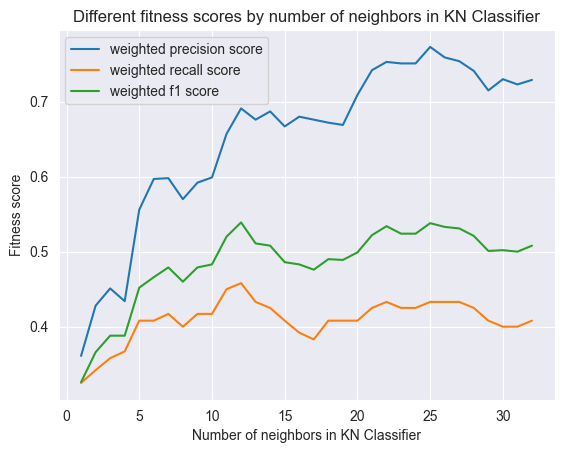

In [40]:
# extra step:
fitness_scores_2, knn_2, y_pred = regress(32, X_train, X_test, y_train, y_test)
fitness_graphs(fitness_scores_2)


As stated before, the fitness scores seemed to be on an upwards trend at n_neighbors=12, which was the limit specified in the problem statement. I was curious what the optimal number of n_neighbors is for model performance, and testing with a limit of 32 reveals that the optimal number of neighbors is at or around 25, according to my model. 

Reflection:
    Overall, this was a very educational project that familiarized me with several topics that I had no experience using, and several more that I was uncomfortable with until now. 
    Probably the hardest part of this project was the weighted graph--I had no experience using networkx, or any kind of graphing module, before we were taught to in class just a short time before I began this project. It took quite a bit of effort to get the graph to a readable state, as early attempts were extremely cluttered and not terribly helpful as far as graphics go. In addition, extra features on the graph, such as color maps, were nontrivial to implement. Making each individual bar the color of the RGB inputs also took quite a bit of effort.
    Having a dataframe be made up of unique RGB inputs, instead of the raw data where each RGB value had several predictions associated with it, made the model much more accurate, and that was probably the solution that helped me the most. In terms of accuracy score, my weighted recall score nearly doubled at its peak due to this step. However, it was still only around 0.45 at its highest which still represents a rather inaccurate model. This can easily be seen in the predictions_vs_centroids bar graph, where several of the output predictions do not match the actual color whatsoever. 
    In terms of making future iterations better, I am a firm believer that having orders of magnitude more input data would make the model much more accurate. In my opinion, the fact that a dataset with only one of each RGB value turned out to be much more accurate than the raw data is a symptom of a small input database. I recognize that gathering significant amounts of data is costly and time-consuming, but in a theoretical world this would have improved the model quite a bit.